**Gaussian Process Regression**

In [29]:
import numpy as np
#rbf kernel
def rbf_kernel(X1, X2, **params):
    length_scale = params.get("length_scale", 1.0)
    variance = params.get("variance", 1.0)

    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    sqdist = (
        np.sum(X1**2, axis=1).reshape(-1, 1)
        + np.sum(X2**2, axis=1)
        - 2 * X1 @ X2.T
    )

    return variance * np.exp(-0.5 * sqdist / length_scale**2)



#linear kernel
def linear_kernel(X1, X2, **params):
    variance = params.get("linear_variance", 1.0)

    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    return variance * (X1 @ X2.T)



#polynomial kernel
def polynomial_kernel(X1, X2, **params):
    degree = params.get("poly_degree", 3)
    bias = params.get("poly_bias", 1.0)
    variance = params.get("poly_variance", 1.0)

    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    return variance * (bias + X1 @ X2.T) ** degree



#Matern Kernel
def matern32_kernel(X1, X2, length_scale=1.0, variance=1.0):
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    dists = np.sqrt(
        np.sum(X1**2,1).reshape(-1,1) +
        np.sum(X2**2,1) -
        2 * X1 @ X2.T
    )

    sqrt3 = np.sqrt(3)
    return variance * (1 + sqrt3 * dists / length_scale) \
           * np.exp(-sqrt3 * dists / length_scale)

#periodic kernel
def periodic_kernel(X1, X2, **params):
    length_scale = params.get("periodic_length_scale", 1.0)
    variance = params.get("periodic_variance", 1.0)
    period = params.get("period", 1.0)

    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    dists = np.sqrt(
        np.sum(X1**2, axis=1).reshape(-1,1)
        + np.sum(X2**2, axis=1)
        - 2 * X1 @ X2.T
    )

    return variance * np.exp(
        -2 * np.sin(np.pi * dists / period)**2 / length_scale**2
    )


    return variance * np.exp(
        -2 * (np.sin(np.pi * dists / period) ** 2) / length_scale**2
    )

#rational quadratic kernel
def rational_quadratic_kernel(X1, X2, **params):
    length_scale = params.get("rq_length_scale", 1.0)
    variance = params.get("rq_variance", 1.0)
    alpha = params.get("rq_alpha", 1.0)

    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    sqdist = (
        np.sum(X1**2, axis=1).reshape(-1, 1)
        + np.sum(X2**2, axis=1)
        - 2 * X1 @ X2.T
    )

    return variance * (
        1 + sqdist / (2 * alpha * length_scale**2)
    ) ** (-alpha)


#Rbf + periodic
def rbf_plus_periodic(X1, X2, length_scale=1.0, variance=1.0):
    return (
        rbf_kernel(
            X1, X2,
            length_scale=length_scale,
            variance=variance
        )
        +
        periodic_kernel(
            X1, X2,
            length_scale=0.7 * length_scale,   # independent hyperparams (scaled)
            variance=variance,
            period=2.0
        )
    )



In [16]:
#kernel addition
def sum_kernel(k1, k2):
    return lambda X1, X2, **params: k1(X1, X2, **params) + k2(X1, X2, **params)

#multiplied kernel
def product_kernel(k1, k2):
    return lambda X1, X2, **params: k1(X1, X2, **params) * k2(X1, X2, **params)


In [24]:
def gaussian_process_regression(
    X_train, y_train, X_test,
    kernel, noise_variance=1e-6,
    **kernel_params
):

    K = kernel(X_train, X_train, **kernel_params)
    K += noise_variance * np.eye(len(X_train))

    K_s = kernel(X_train, X_test, **kernel_params)
    K_ss = kernel(X_test, X_test, **kernel_params)

    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

    mu = K_s.T @ alpha
    v = np.linalg.solve(L, K_s)
    cov = K_ss - v.T @ v

    return mu.ravel(), cov


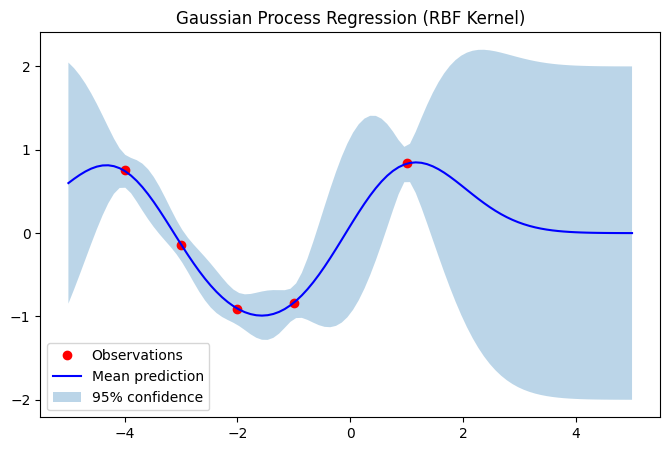

In [37]:
#With sample data
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
y_train = np.sin(X_train).ravel()

# Test points
X_test = np.linspace(-5, 5, 100).reshape(-1,1)

# Run GP
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=rbf_kernel,
    noise_variance=0.01,
    length_scale=1.0,
    variance=1.0
)

# Standard deviation
std = np.sqrt(np.diag(cov))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'ro', label='Observations')
plt.plot(X_test, mu, 'b-', label='Mean prediction')
plt.fill_between(
    X_test.ravel(),
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label='95% confidence'
)
plt.legend()
plt.title("Gaussian Process Regression (RBF Kernel)")
plt.show()

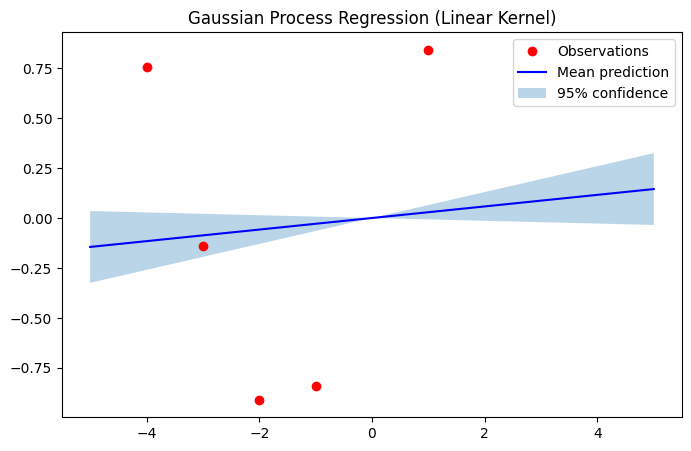

In [30]:
#With sample data
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
y_train = np.sin(X_train).ravel()

# Test points
X_test = np.linspace(-5, 5, 100).reshape(-1,1)

# Run GP
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=linear_kernel,
    noise_variance=0.01,
    length_scale=1.0,
    variance=1.0
)

# Standard deviation
std = np.sqrt(np.diag(cov))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'ro', label='Observations')
plt.plot(X_test, mu, 'b-', label='Mean prediction')
plt.fill_between(
    X_test.ravel(),
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label='95% confidence'
)
plt.legend()
plt.title("Gaussian Process Regression (Linear Kernel)")
plt.show()


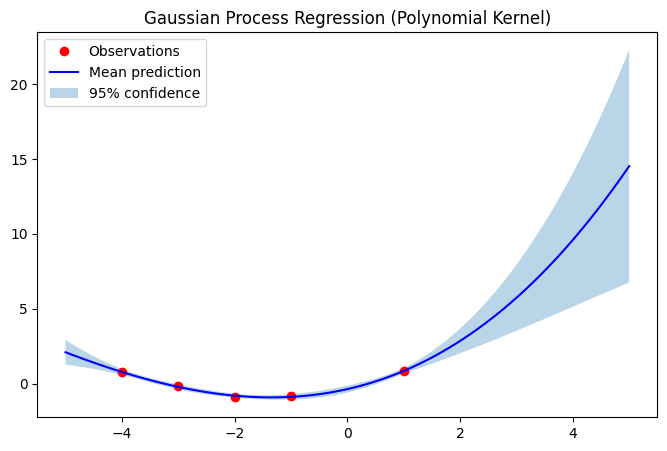

In [31]:
#With sample data
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
y_train = np.sin(X_train).ravel()

# Test points
X_test = np.linspace(-5, 5, 100).reshape(-1,1)

# Run GP
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=polynomial_kernel,
    noise_variance=0.01,
    length_scale=1.0,
    variance=1.0
)

# Standard deviation
std = np.sqrt(np.diag(cov))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'ro', label='Observations')
plt.plot(X_test, mu, 'b-', label='Mean prediction')
plt.fill_between(
    X_test.ravel(),
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label='95% confidence'
)
plt.legend()
plt.title("Gaussian Process Regression (Polynomial Kernel)")
plt.show()


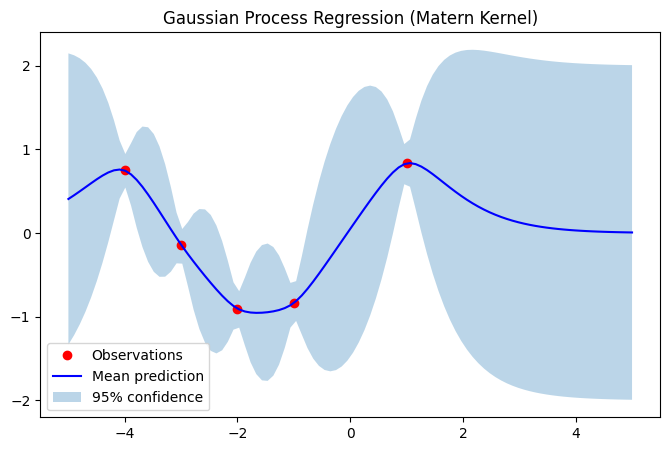

In [32]:
#With sample data
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
y_train = np.sin(X_train).ravel()

# Test points
X_test = np.linspace(-5, 5, 100).reshape(-1,1)

# Run GP
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=matern32_kernel,
    noise_variance=0.01,
    length_scale=1.0,
    variance=1.0
)

# Standard deviation
std = np.sqrt(np.diag(cov))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'ro', label='Observations')
plt.plot(X_test, mu, 'b-', label='Mean prediction')
plt.fill_between(
    X_test.ravel(),
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label='95% confidence'
)
plt.legend()
plt.title("Gaussian Process Regression (Matern Kernel)")
plt.show()


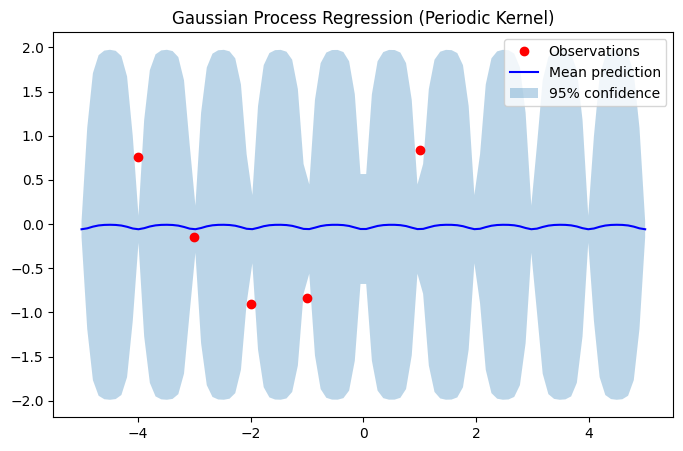

In [33]:
#With sample data
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
y_train = np.sin(X_train).ravel()

# Test points
X_test = np.linspace(-5, 5, 100).reshape(-1,1)

# Run GP
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=periodic_kernel,
    noise_variance=0.01,
    length_scale=1.0,
    variance=1.0
)

# Standard deviation
std = np.sqrt(np.diag(cov))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'ro', label='Observations')
plt.plot(X_test, mu, 'b-', label='Mean prediction')
plt.fill_between(
    X_test.ravel(),
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label='95% confidence'
)
plt.legend()
plt.title("Gaussian Process Regression (Periodic Kernel)")
plt.show()


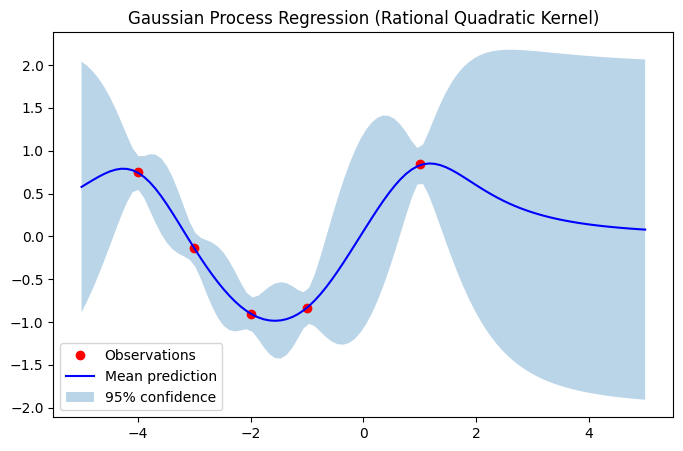

In [34]:
#With sample data
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
y_train = np.sin(X_train).ravel()

# Test points
X_test = np.linspace(-5, 5, 100).reshape(-1,1)

# Run GP
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=rational_quadratic_kernel,
    noise_variance=0.01,
    length_scale=1.0,
    variance=1.0
)

# Standard deviation
std = np.sqrt(np.diag(cov))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'ro', label='Observations')
plt.plot(X_test, mu, 'b-', label='Mean prediction')
plt.fill_between(
    X_test.ravel(),
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label='95% confidence'
)
plt.legend()
plt.title("Gaussian Process Regression (Rational Quadratic Kernel)")
plt.show()


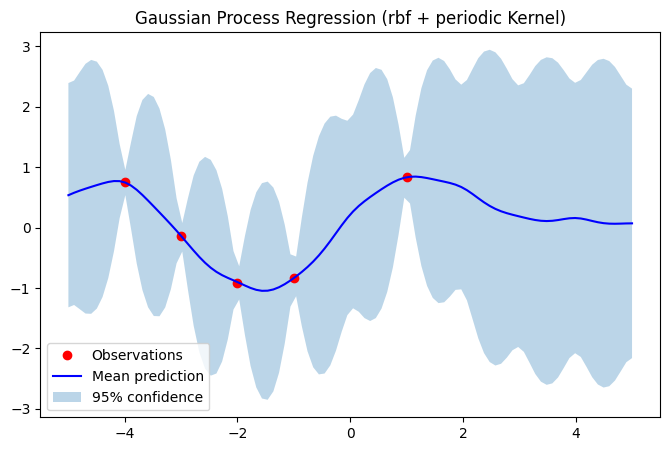

In [35]:
#With sample data
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
y_train = np.sin(X_train).ravel()

# Test points
X_test = np.linspace(-5, 5, 100).reshape(-1,1)

# Run GP
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=rbf_plus_periodic,
    noise_variance=0.01,
    length_scale=1.0,
    variance=1.0
)

# Standard deviation
std = np.sqrt(np.diag(cov))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'ro', label='Observations')
plt.plot(X_test, mu, 'b-', label='Mean prediction')
plt.fill_between(
    X_test.ravel(),
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label='95% confidence'
)
plt.legend()
plt.title("Gaussian Process Regression (rbf + periodic Kernel)")
plt.show()


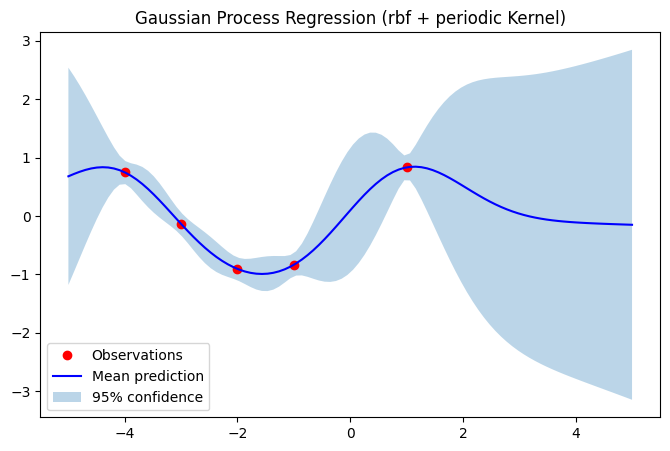

In [36]:
#With sample data
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
y_train = np.sin(X_train).ravel()

# Test points
X_test = np.linspace(-5, 5, 100).reshape(-1,1)

def gaussian_process_regression(
    X_train, y_train, X_test,
    kernel, noise_variance=1e-6,
    **kernel_params
):

    K = kernel(X_train, X_train, **kernel_params)
    K += noise_variance * np.eye(len(X_train))

    K_s = kernel(X_train, X_test, **kernel_params)
    K_ss = kernel(X_test, X_test, **kernel_params)

    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

    mu = K_s.T @ alpha
    v = np.linalg.solve(L, K_s)
    cov = K_ss - v.T @ v

    return mu.ravel(), cov

# Run GP
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=sum_kernel(rbf_kernel, linear_kernel),
    noise_variance=0.01,
    length_scale=1.0,
    variance=1.0
)

# Standard deviation
std = np.sqrt(np.diag(cov))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'ro', label='Observations')
plt.plot(X_test, mu, 'b-', label='Mean prediction')
plt.fill_between(
    X_test.ravel(),
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label='95% confidence'
)
plt.legend()
plt.title("Gaussian Process Regression (rbf + periodic Kernel)")
plt.show()


**Example: Using Stock Price Generated Data**

In [38]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Time index (e.g. trading days)
n_days = 500
t = np.arange(n_days)

# 1️⃣ Long-term trend
trend = 0.001 * t

# 2️⃣ Market cycles (business cycles)
cycle = 0.05 * np.sin(2 * np.pi * t / 120)

# 3️⃣ Smooth latent variation (GP-like)
def smooth_noise(n, length_scale=30):
    x = np.arange(n).reshape(-1, 1)
    sqdist = (x - x.T) ** 2
    K = np.exp(-0.5 * sqdist / length_scale**2)
    return np.random.multivariate_normal(
        mean=np.zeros(n), cov=0.01 * K
    )

latent = smooth_noise(n_days)

# 4️⃣ Volatility clustering
volatility = 0.01 + 0.02 * np.abs(np.sin(t / 40))
noise = volatility * np.random.randn(n_days)

# Log-price
log_price = 4 + trend + cycle + latent + noise

# Convert to price
price = np.exp(log_price)

# Build dataset
df = pd.DataFrame({
    "day": t,
    "log_price": log_price,
    "price": price,
    "volatility": volatility
})

df.head()


,day,log_price,price,volatility
0,0,3.886806,48.754914,0.010000
1,1,3.896951,49.252035,0.010500
2,2,3.861073,47.516306,0.011000
3,3,3.882682,48.554253,0.011499
4,4,3.868350,47.863361,0.011997


In [41]:
#Inputs
#GP expects x to have dimension (n,1) and y to have dimension (n,)
X = df["day"].values.reshape(-1, 1)   # shape (n, 1)
y = df["log_price"].values            # shape (n,)

#Train - Test Split
train_size = int(0.8 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

#Kernel
kernel = sum_kernel(
    linear_kernel,
    sum_kernel(rbf_kernel, periodic_kernel)
)


In [51]:
mu, cov = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=kernel,
    noise_variance=0.01,

    # Linear (trend)
    linear_variance=0.01,

    # RBF (smooth local behavior)
    length_scale=30.0,
    variance=0.5,

    # Periodic (market cycles)
    periodic_length_scale=15.0,
    periodic_variance=0.2,
    period=120.0
)


In [52]:
std = np.sqrt(np.diag(cov))

#Converting to Price Space
price_pred = np.exp(mu)

#Confidence Bands
price_upper = np.exp(mu + 2*std)
price_lower = np.exp(mu - 2*std)


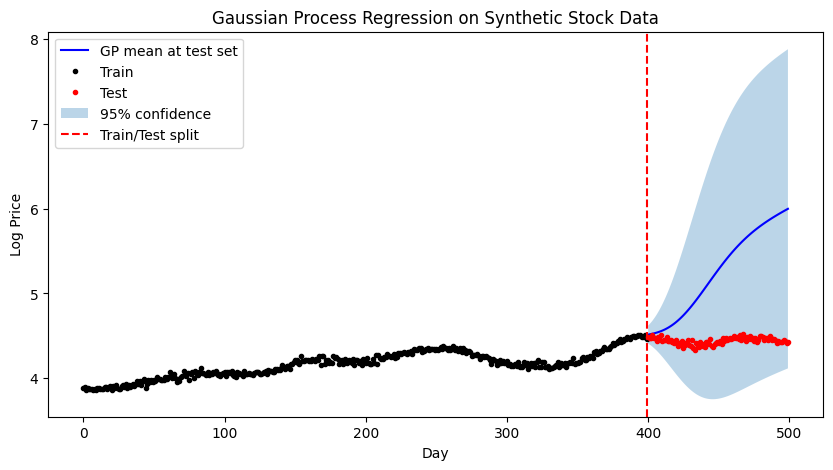

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# plt.plot(X[:,0], df["log_price"], "k.", alpha=0.4, label="Observed (log-price)")
plt.plot(X_test[:,0], mu, "b-", label="GP mean at test set")
plt.plot(X_train[:,0], y_train, "k.", label="Train")
plt.plot(X_test[:,0], y_test, "r.", label="Test")

plt.fill_between(
    X_test[:,0],
    mu - 2*std,
    mu + 2*std,
    alpha=0.3,
    label="95% confidence"
)

plt.axvline(X_train[-1,0], color="r", linestyle="--", label="Train/Test split")

plt.legend()
plt.title("Gaussian Process Regression on Synthetic Stock Data")
plt.xlabel("Day")
plt.ylabel("Log Price")
plt.show()


**Example: Reactor Data Kinetics**

In [62]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Constants
R = 8.314  # J/mol/K
Ea = 50000  # J/mol
k0 = 1e6    # 1/s

# Time grid
t = np.linspace(0, 500, 80)  # seconds

# Temperature profile (non-constant, realistic)
T = 300 + 10 * np.sin(2 * np.pi * t / 500)  # K

# True rate constant
k = k0 * np.exp(-Ea / (R * T))

# Initial concentration
C0 = 1.0  # mol/L

# Solve analytically for batch reactor
C_A = C0 * np.exp(-k * t)

# Add measurement noise
noise = 0.02 * np.random.randn(len(C_A))
C_A_obs = C_A + noise

# Dataset
df = pd.DataFrame({
    "time_s": t,
    "temperature_K": T,
    "k_true": k,
    "C_A_true": C_A,
    "C_A_obs": C_A_obs
})

df.head()


,time_s,temperature_K,k_true,C_A_true,C_A_obs
0,0.000000,300.000000,0.001967,1.000000,1.009934
1,6.329114,300.794502,0.002074,0.986956,0.984191
2,12.658228,301.583980,0.002186,0.972709,0.985663
3,18.987342,302.363444,0.002301,0.957246,0.987707
4,25.316456,303.127966,0.002420,0.940582,0.935899


In [63]:
# Inputs and target
X = df[["time_s", "temperature_K"]].values   # (n, 2)
y = df["C_A_obs"].values                     # (n,)

#Split Data into train and test sets
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]




Kernel = Linear(time) + RBF(time, temperature) + Rational Quadratic


In [64]:
#Kernel
kernel = sum_kernel(
    linear_kernel,
    sum_kernel(rbf_kernel, rational_quadratic_kernel)
)

In [65]:
#Fit into Gaussian Process Regression Model
mu_gp, cov_gp = gaussian_process_regression(
    X_train, y_train, X_test,
    kernel=kernel,
    noise_variance=0.002,

    # Linear trend
    linear_variance=0.02,

    # RBF
    length_scale=50.0,
    variance=0.2,

    # Rational Quadratic
    rq_length_scale=30.0,
    rq_variance=0.1,
    rq_alpha=0.7
)

std_gp = np.sqrt(np.diag(cov_gp))


In [66]:
#Baseline from the Kinetic Model
R = 8.314
Ea = 50000
k0 = 1e6

def arrhenius_CA(t, T, C0=1.0):
    k = k0 * np.exp(-Ea / (R * T))
    return C0 * np.exp(-k * t)

C_phys_train = arrhenius_CA(
    X_train[:,0], X_train[:,1]
)

C_phys_test = arrhenius_CA(
    X_test[:,0], X_test[:,1]
)


In [67]:
#Physics Informed GP
residual_train = y_train - C_phys_train

#GP no the residuals
mu_res, cov_res = gaussian_process_regression(
    X_train, residual_train, X_test,
    kernel=kernel,
    noise_variance=0.001,

    linear_variance=0.01,
    length_scale=40.0,
    variance=0.1,
    rq_length_scale=25.0,
    rq_variance=0.05,
    rq_alpha=0.8
)

std_res = np.sqrt(np.diag(cov_res))


In [68]:
#Physics Informed Prediction
mu_phys_gp = C_phys_test + mu_res
std_phys_gp = std_res


In [69]:
#Comparison
rmse_phys = np.sqrt(np.mean((C_phys_test - y_test)**2))
rmse_gp = np.sqrt(np.mean((mu_gp - y_test)**2))
rmse_phys_gp = np.sqrt(np.mean((mu_phys_gp - y_test)**2))

print("Arrhenius RMSE:", rmse_phys)
print("Pure GP RMSE:", rmse_gp)
print("Physics-GP RMSE:", rmse_phys_gp)


Arrhenius RMSE: 0.022692943048310963
Pure GP RMSE: 0.07487496165877806
Physics-GP RMSE: 0.03777559057692825


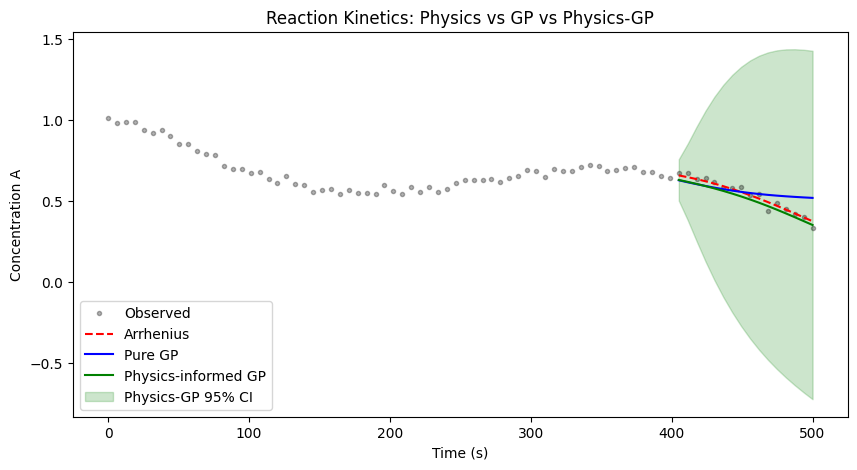

In [70]:
#Plot
import matplotlib.pyplot as plt

t_test = X_test[:,0]

plt.figure(figsize=(10,5))

plt.plot(
    df["time_s"], df["C_A_obs"],
    "k.", alpha=0.3, label="Observed"
)

plt.plot(t_test, C_phys_test, "r--", label="Arrhenius")
plt.plot(t_test, mu_gp, "b-", label="Pure GP")
plt.plot(t_test, mu_phys_gp, "g-", label="Physics-informed GP")

plt.fill_between(
    t_test,
    mu_phys_gp - 2*std_phys_gp,
    mu_phys_gp + 2*std_phys_gp,
    color="green", alpha=0.2,
    label="Physics-GP 95% CI"
)

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Concentration A")
plt.title("Reaction Kinetics: Physics vs GP vs Physics-GP")
plt.show()


**Example: Plant Optimization**

In [75]:
import numpy as np

def true_process(T, tau, CA0):
    # Normalized variables
    Tn = (T - 300) / 50
    taun = (tau - 5) / 5
    CA0n = (CA0 - 1.0)

    # Nonlinear yield surface
    Y = (
        0.8
        + 0.15 * np.tanh(Tn)
        + 0.10 * np.exp(-taun**2)
        - 0.12 * CA0n**2
        + 0.05 * np.sin(2*np.pi*Tn)
    )

    # Measurement noise
    return Y + 0.01 * np.random.randn()

#Variable Bounds
bounds = {
    "T": (280, 360),
    "tau": (1, 10),
    "CA0": (0.8, 1.2)
}

#Data Generation Experiment
np.random.seed(0)
n_initial = 15

X = []
y = []

for _ in range(n_initial):
    T = np.random.uniform(*bounds["T"])
    tau = np.random.uniform(*bounds["tau"])
    CA0 = np.random.uniform(*bounds["CA0"])

    Y = true_process(T, tau, CA0)

    X.append([T, tau, CA0])
    y.append(Y)

#Data Input for GPR
X = np.array(X)
y = np.array(y)


In [77]:
#Input Scaling
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

Xs = (X - X_mean) / X_std

#Kernel
kernel = sum_kernel(
    linear_kernel,
    sum_kernel(rbf_kernel, rational_quadratic_kernel)
)


In [79]:
#Fitting into GPR Model
mu_surr, cov_surr = gaussian_process_regression(
    Xs, y, Xs,
    kernel=kernel,
    noise_variance=0.01,

    linear_variance=0.05,

    length_scale=1.0,
    variance=0.3,

    rq_length_scale=0.7,
    rq_variance=0.2,
    rq_alpha=0.8
)

#Expected improvement
from scipy.stats import norm

def expected_improvement(Xcand, Xtrain, ytrain, kernel, params):
    mu, cov = gaussian_process_regression(
        Xtrain, ytrain, Xcand,
        kernel=kernel,
        **params
    )
    sigma = np.sqrt(np.diag(cov))

    y_best = np.max(ytrain)
    z = (mu - y_best) / sigma

    EI = (mu - y_best) * norm.cdf(z) + sigma * norm.pdf(z)
    EI[sigma == 0] = 0
    return EI


In [80]:
#Optimization Loop
for iteration in range(10):

    # Candidate grid
    T_grid = np.linspace(*bounds["T"], 30)
    tau_grid = np.linspace(*bounds["tau"], 20)
    CA0_grid = np.linspace(*bounds["CA0"], 15)

    candidates = np.array([
        [(T - X_mean[0]) / X_std[0],
         (tau - X_mean[1]) / X_std[1],
         (CA0 - X_mean[2]) / X_std[2]]
        for T in T_grid for tau in tau_grid for CA0 in CA0_grid
    ])

    EI = expected_improvement(
        candidates, Xs, y,
        kernel=kernel,
        params=dict(
            noise_variance=0.01,
            linear_variance=0.05,
            length_scale=1.0,
            variance=0.3,
            rq_length_scale=0.7,
            rq_variance=0.2,
            rq_alpha=0.8
        )
    )

    x_next = candidates[np.argmax(EI)]

    # Convert back to physical units
    x_phys = x_next * X_std + X_mean

    # Run plant
    y_next = true_process(*x_phys)

    # Update dataset
    Xs = np.vstack([Xs, x_next])
    y = np.append(y, y_next)

    print(f"Iteration {iteration+1}, Yield = {y_next:.3f}")


Iteration 1, Yield = 0.906
Iteration 2, Yield = 0.974
Iteration 3, Yield = 0.953
Iteration 4, Yield = 0.971
Iteration 5, Yield = 0.903
Iteration 6, Yield = 0.976
Iteration 7, Yield = 1.062
Iteration 8, Yield = 1.082
Iteration 9, Yield = 1.011
Iteration 10, Yield = 1.047
